# U-Net Transfer Learning Tutorial: Cost-Efficient Building Segmentation

This notebook teaches you how to train a **U-Net** model to find **building footprints** in aerial images. Building maps are a key first step for **damage assessment**: once we know *where* buildings are, we can later compare pre- and post-event images to estimate damage.

## Why this notebook?
- **Faster training:** We use **transfer learning** (a pretrained encoder) so the model starts with basic visual knowledge and needs fewer epochs.
- **Lower compute cost:** We **tile** large images into **512×512** patches and use **mixed precision (AMP)** to save memory and time.
- **Practical for disaster response:** Lightweight models + tiling help reach “good enough” results quickly.

## What you’ll do
1. **Download** a small subset of the Massachusetts Buildings dataset (images + binary masks).  
2. **Tile** big images into patches for efficient training on a standard GPU.  
3. **Build U-Net** with a **pretrained encoder** (default: MobileNetV2 for speed).  
4. **Train** with a **freeze → unfreeze** schedule, **early stopping**, and an **LR scheduler**.  
5. **Evaluate** using **IoU** and **Dice**, **visualize** predictions, and **measure inference speed**.  
6. **(Optional)** Save the best model checkpoint.

## Key ideas (simple terms)
- **Transfer learning:** Start from a model that already recognizes edges/shapes; fine-tune it for buildings.  
- **Tiling:** Cut large scenes into small squares so training fits in memory and runs faster.  
- **Metrics:**  
  - **IoU (Intersection over Union):** Overlap between prediction and ground truth.  
  - **Dice:** Another overlap score, often a bit more stable on small objects.

## Requirements & tips
- Use **Google Colab with GPU** (Runtime → Change runtime type → GPU).

## Cell 1 — Mount Google Drive (optional but recommended)

We mount Google Drive so that **datasets, patches, and model checkpoints** are saved in your Drive and **persist after the Colab session ends**.  
- You’ll be asked to **authorize** access; a `drive` folder will appear at `/content/drive`.  
- If you prefer **faster I/O** (slightly quicker training) and don’t need persistence, you can skip this and write to `/content/…` instead.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cell 2 — Install required libraries

We install the packages used throughout the notebook:

- `segmentation-models-pytorch (SMP)`: high-level segmentation models (we’ll use **U-Net** with a pretrained encoder).  
- `timm`: image models & pretrained weights for the U-Net encoder.  
- `torchmetrics`: clean implementations of metrics (we’ll use IoU).  
- `tifffile`: safe reading of `.tif/.tiff` images (common in aerial datasets).

> **Tip:** Keep versions consistent. If you hit import/version errors (especially for `albumentations` or `opencv` later), use the **single consolidated line** in the next cell’s comment (the one that also installs `albumentations` and `opencv-python`) and **comment out** the older `timm==0.5.4` install. Colab often has OpenCV, but `albumentations` usually needs to be installed.

---

In [ ]:
!pip install segmentation-models-pytorch==0.3.3 timm==0.5.4
!pip install torchmetrics segmentation_models_pytorch
!pip -q install tifffile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of segmentation-models-pytorch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install segmentation-models-pytorch==0.3.3 and timm==0.5.4 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested timm==0.5.4
    segmentation-models-pytorch 0.3.3 depends on timm==0.9.2

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


## Cell 3 — Setup, imports, and reproducibility

This cell:
- Imports standard utilities (`os`, `pathlib`, `requests`, `re`, etc.) and core libs (**PyTorch**, **Albumentations**, **OpenCV**, **Matplotlib**).  
- Imports **SMP** (U-Net) and **torchmetrics** (IoU).  
- Detects the device (`cuda` if GPU is available).  
- Sets **random seeds** to make results more repeatable (training still has some randomness).

**Why these pieces matter (simple terms):**
- **Albumentations**: fast, reliable image augmentations for better generalization.  
- **OpenCV**: reading/writing images and basic image ops.  
- **Seeds**: help you get similar results across runs.

---

In [ ]:
# ============================================================
# U-Net (transfer learning) tutorial for Building Segmentation
# Dataset: Massachusetts Buildings (subset, auto-download)
# Framework: PyTorch + segmentation_models_pytorch (SMP)
# Designed for Google Colab (GPU runtime recommended)
# ============================================================

# -------------------------
# 0) Basic setup & installs
# -------------------------
#!pip -q install segmentation-models-pytorch==0.3.3 timm==0.9.16 albumentations==1.4.8 opencv-python==4.10.0.84 torchmetrics==1.4.0

import os, re, math, time, random, shutil, glob, io, requests
from pathlib import Path
from urllib.parse import urljoin

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from torchmetrics.classification import BinaryJaccardIndex

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# For reproducibility (still stochastic due to GPU/threads/augs)
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED);
if DEVICE.type == "cuda": torch.cuda.manual_seed_all(SEED)


Device: cuda


## Cell 4 — Tutorial size and output folders

Here you control **how big** the run is and **where** files go:

- `NUM_TRAIN`, `NUM_VALID`, `NUM_TEST`: how many large tiles to fetch from the dataset.  
  - Increase these for better accuracy (more data), **at the cost of time/compute**.  
- `TILE_SIZE` and `TILE_STRIDE`: how we **cut big images into patches**.  
  - `TILE_SIZE=512` is a sweet spot for Colab GPUs.  
  - `TILE_STRIDE=512` means **no overlap** (faster, fewer patches).  
    Use a smaller stride (e.g., `256`) for overlapping patches (more data, smoother learning, but slower).
- `DATA_ROOT`: base folder for everything. You set it to your **Google Drive** path so data and models are saved.  
  - `RAW_DIR`: downloaded images/masks.  
  - `PATCH_DIR`: 512×512 patches produced from the large images.

> **Tip:** If you want slightly faster runs and don’t need persistence, set  
> `DATA_ROOT = Path("/content/buildings_demo")`  
> (stays only for the current session).

In [ ]:
# ---------------------------------------
# 1) Choose how big you want the dataset
# ---------------------------------------
# Feel free to increase NUM_* to train longer and get better scores.
NUM_TRAIN = 30     # number of large 1500x1500 tiles to fetch for training
NUM_VALID = 4      # validation set size
NUM_TEST  = 6      # test set size
TILE_SIZE = 512    # tiling size for training patches
TILE_STRIDE = 512  # stride; set <= TILE_SIZE for overlapping patches

# Where to put everything
DATA_ROOT = Path("/content/drive/MyDrive/Dataset1")
RAW_DIR   = DATA_ROOT / "RAW_Data"
PATCH_DIR = DATA_ROOT / "PATCH_Data"
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PATCH_DIR, exist_ok=True)


## Cell 5 — Download a small, paired subset (images + masks)

This cell pulls a **subset** of the Massachusetts Buildings dataset directly from the public folder (it has simple directory listings):
- `sat/` = aerial images  
- `map/` = matching **binary building masks**

**What happens:**
- `list_files_from_dir(...)` scrapes the index page and collects filenames (e.g., `*.tif`).
- We limit how many files we take using the numbers you set earlier (`NUM_TRAIN`, `NUM_VALID`, `NUM_TEST`).
- We keep **only pairs** where both the image and its mask exist (same stem).
- `download_file(...)` saves them into `RAW_DIR/<split>/images` and `RAW_DIR/<split>/masks`.

**Why this matters (cost & simplicity):**
- We **don’t download the full dataset**, just enough for a fast demo.
- Using direct URLs avoids accounts/tokens and reduces setup time.

**Notes:**
- If a download fails momentarily, re-run the cell; it skips files that already exist.
- Internet hiccups can happen in Colab; the function is idempotent (safe to re-run).

---


In [ ]:
# --------------------------------------------------------
# 2) Download a subset of the Massachusetts Buildings data
#    Source provides directory listings with sat/ (images)
#    and map/ (binary masks). We'll parse and download N.
# --------------------------------------------------------
BASE = "https://www.cs.toronto.edu/~vmnih/data/mass_buildings/"
SETS = {
    "train": {"sat": "train/sat/", "map": "train/map/"},
    "valid": {"sat": "valid/sat/", "map": "valid/map/"},
    "test":  {"sat": "test/sat/" , "map": "test/map/" },
}

def list_files_from_dir(url, ext_pattern):
    """Parse a simple index listing and return matching filenames."""
    html = requests.get(url).text
    # filenames appear as href="name"
    names = re.findall(r'href="([^"]+)"', html)
    files = [n for n in names if re.search(ext_pattern, n)]
    return sorted(files)

def download_file(url, out_path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.exists():
        return
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk: f.write(chunk)

def download_subset(n_train=NUM_TRAIN, n_valid=NUM_VALID, n_test=NUM_TEST):
    for split, paths in SETS.items():
        sat_url = urljoin(BASE, paths["sat"])
        map_url = urljoin(BASE, paths["map"])
        sat_files = list_files_from_dir(sat_url, r"\.tif{1,2}f?$")  # .tif or .tiff
        map_files = list_files_from_dir(map_url, r"\.tif{1,2}f?$")

        # Choose how many for this split
        n = {"train": n_train, "valid": n_valid, "test": n_test}[split]
        sat_files = sat_files[:n]
        # Keep only stems that also exist in maps (they have same stems)
        sat_stems = [Path(x).stem for x in sat_files]
        map_keep = []
        for mf in map_files:
            st = Path(mf).stem
            if st in sat_stems:
                map_keep.append(mf)
        # Download pairs
        for sf in sat_files:
            stem = Path(sf).stem
            mf = [m for m in map_keep if Path(m).stem == stem]
            if not mf:
                continue
            mf = mf[0]
            sat_out = RAW_DIR / split / "images" / f"{stem}.tif"
            map_out = RAW_DIR / split / "masks"  / f"{stem}.tif"
            download_file(urljoin(sat_url, sf), sat_out)
            download_file(urljoin(map_url, mf), map_out)

download_subset()
print("Download complete. RAW_DIR =", RAW_DIR)

Download complete. RAW_DIR = /content/drive/MyDrive/Dataset1/RAW_Data


## Cell 6 — Clean old patches & make new 512×512 tiles (with smart sampling)

Here we (a) **remove old patches** to avoid mixing runs, (b) read masks robustly, and (c) **tile** big 1500×1500 images into **512×512** patches.

**Key pieces:**
- `read_mask_any(...)`: tries `tifffile` → `PIL` → `OpenCV` so we can read various TIFF encodings reliably.
- `binarize_mask_raw(...)`: standardizes masks to **0 or 255** even if the source is `0/1`, `0/255`, or `0/65535`.
- `tile_split(...)`:
  - Pads images to multiples of `TILE_SIZE` (so tiles fit perfectly).
  - Slides a 512×512 window with stride `TILE_STRIDE` (no overlap if stride=512).
  - **Class balance trick (train only):**
    - `pos_min_pix` keeps tiles with at least a bit of building signal,  
    - `keep_empty_every` keeps *some* empty tiles to prevent bias.
  - Saves tiles to `PATCH_DIR/<split>/images` and `/masks`.

**Why tiling helps (simple terms):**
- Smaller patches **fit in memory**, so you can use **bigger batches** and finish faster.
- We avoid training on lots of **totally empty** tiles, which speeds up learning.

**Outputs:**
- A count of how many patches were saved per split, plus totals for train/valid/test.

**Tips:**
- If you want more data (better accuracy), reduce `TILE_STRIDE` (e.g., 256) to create **overlapping tiles**. It’s slower but gives more variety.
- If you see “[WARN] mask is empty…” it’s okay; the code still proceeds and samples a few empties intentionally.

---

In [ ]:
# --- CLEAN previous patches so we don't mix runs ---
import shutil
shutil.rmtree(PATCH_DIR, ignore_errors=True)

import tifffile as tiff
from PIL import Image

def read_mask_any(path):
    """
    Robust TIFF reader for binary masks.
    Tries: tifffile -> PIL -> OpenCV.
    Returns a 2D numpy array.
    """
    arr = None
    try:
        arr = tiff.imread(str(path))
    except Exception:
        arr = None
    if arr is None or getattr(arr, "size", 0) == 0:
        try:
            with Image.open(path) as im:
                arr = np.array(im)
        except Exception:
            arr = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)

    if arr is None:
        return None
    if arr.ndim == 3:
        arr = arr[..., 0]
    return arr

def binarize_mask_raw(mask):
    """
    Works with 0/1, 0/255, 0/65535, etc.
    Output: uint8 {0,255}
    """
    m = mask.astype(np.float32)
    mx = float(m.max())

    if mx == 0:
        return np.zeros_like(mask, dtype=np.uint8)  # still zero (warn later)
    if mx <= 1.0:
        m = (m > 0).astype(np.uint8) * 255
    else:
        thr = 127 if mx <= 255 else mx / 2.0
        m = (m > thr).astype(np.uint8) * 255
    return m

def tile_split(split, tile=512, stride=512, pos_min_pix=10*255, keep_empty_every=8):
    im_dir = RAW_DIR / split / "images"
    ms_dir = RAW_DIR / split / "masks"
    out_img = PATCH_DIR / split / "images"
    out_msk = PATCH_DIR / split / "masks"
    out_img.mkdir(parents=True, exist_ok=True)
    out_msk.mkdir(parents=True, exist_ok=True)

    kept = 0
    for im_path in sorted(im_dir.glob("*.tif")):
        stem = im_path.stem
        m_path = ms_dir / f"{stem}.tif"

        img = cv2.imread(str(im_path), cv2.IMREAD_COLOR)
        raw_m = read_mask_any(m_path)

        if img is None or raw_m is None:
            print("Skipping unreadable:", stem)
            continue

        msk = binarize_mask_raw(raw_m)
        if msk.sum() == 0:
            print(f"[WARN] mask is empty after binarize: {m_path.name} (raw max={raw_m.max()})")

        img = pad_to_multiple(img, tile)
        msk = pad_to_multiple(msk, tile)
        H, W = img.shape[:2]

        for y in range(0, H - tile + 1, stride):
            for x in range(0, W - tile + 1, stride):
                patch_im = img[y:y+tile, x:x+tile]
                patch_ms = msk[y:y+tile, x:x+tile]

                if split == "train":
                    is_pos = (patch_ms.sum() >= pos_min_pix)
                    keep_empty = (((y // max(1, stride)) + (x // max(1, stride))) % keep_empty_every == 0)
                    if not (is_pos or keep_empty):
                        continue

                pid = f"{stem}_{y:04d}_{x:04d}.png"
                cv2.imwrite(str(out_img / pid), patch_im)
                cv2.imwrite(str(out_msk / pid), patch_ms)
                kept += 1
    return kept

for sp in ["train","valid","test"]:
    k = tile_split(sp, tile=TILE_SIZE, stride=TILE_STRIDE)
    print(f"{sp}: kept {k} patches")

def count_patches(base): return len(list((base/"images").glob("*.png")))
print("Train patches:", count_patches(PATCH_DIR/"train"))
print("Valid patches:", count_patches(PATCH_DIR/"valid"))
print("Test  patches:", count_patches(PATCH_DIR/"test"))

train: kept 267 patches
valid: kept 36 patches
test: kept 54 patches
Train patches: 267
Valid patches: 36
Test  patches: 54


## Cell 7 — Dataset class, augmentations, and DataLoaders

This cell builds the **PyTorch Dataset** / **DataLoader** so training code can iterate over batches easily.

**Augmentations & normalization:**
- `IMAGENET_MEAN/STD`: normalize images to match the encoder’s pretraining (transfer learning best practice).
- **Train augs** (mild but useful): random rotations/flips, small shift/scale/rotate, light brightness/contrast, light noise.
- **Valid/Test**: only normalize (no random changes).

**`BuildingPatches` dataset:**
- Loads a tile (`.png`) and its **matching mask** by filename.
- Converts the mask to **binary 0/1** safely, regardless of original format.
- Applies augmentations and returns **tensors** in channel-first format (`C×H×W`).

**DataLoaders:**
- `train_dl` (shuffled), `valid_dl`, `test_dl`.
- `batch_size=8` is a safe default for Colab; **if you get OOM**, lower it (e.g., 4 or 2).
- `num_workers=2` speeds up loading a bit without overloading Colab.

**Why this matters (transfer learning & cost):**
- ImageNet normalization helps the **pretrained encoder** work well from the start.
- Light augmentations improve generalization **without heavy compute**.

**At a glance:**
- After this cell, `len(train_ds)`, `len(valid_ds)`, and `len(test_ds)` tell you how many **patches** you’ll train on.
- You’re now ready to define the **U-Net model** and start training.

In [ ]:
# -------------------------------------------------
# 4) Dataset & Augmentations (ImageNet normalization)
# -------------------------------------------------
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_REFLECT),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

valid_tfms = A.Compose([
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

class BuildingPatches(Dataset):
    def __init__(self, root, transforms=None):
        self.imgs = sorted((root/"images").glob("*.png"))
        self.masks = [root/"masks"/p.name for p in self.imgs]
        self.transforms = transforms

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        # Read image (BGR->RGB) and mask (grayscale)
        img = cv2.imread(str(self.imgs[idx]), cv2.IMREAD_COLOR)[:, :, ::-1]
        msk = cv2.imread(str(self.masks[idx]), cv2.IMREAD_GRAYSCALE)

        # --- Make mask robust: accept 0/255 or 0/1, force to float 0/1 ---
        msk = msk.astype(np.float32)
        if msk.max() > 1:           # e.g., 255
            msk /= 255.0
        msk = (msk > 0.5).astype(np.float32)   # hard binarize

        if self.transforms:
            out = self.transforms(image=img, mask=msk)
            img = out["image"]                   # CxHxW float tensor
            msk = out["mask"]                    # HxW (tensor or np)
            # Ensure tensor, channel-first, float, and binary
            if not isinstance(msk, torch.Tensor):
                msk = torch.from_numpy(msk)
            if msk.ndim == 2:
                msk = msk.unsqueeze(0)           # 1xHxW
            msk = (msk > 0.5).float()
        else:
            img = TF.to_tensor(img)
            img = TF.normalize(img, IMAGENET_MEAN, IMAGENET_STD)
            msk = torch.from_numpy(msk).unsqueeze(0).float()  # 1xHxW

        return img.float(), msk.float()


train_ds = BuildingPatches(PATCH_DIR/"train", transforms=train_tfms)
valid_ds = BuildingPatches(PATCH_DIR/"valid", transforms=valid_tfms)
test_ds  = BuildingPatches(PATCH_DIR/"test",  transforms=valid_tfms)
print(len(train_ds), len(valid_ds), len(test_ds))

BATCH_SIZE = 8
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds , batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


267 36 54


## Cell — Quick sanity checks on masks

Before training, we verify that our **patch masks** are truly **binary** after preprocessing:

- We randomly sample a few mask files and print their **unique values**.  
  - Expect to see only **0** (background) and **255** (building).  
- We also estimate the **foreground fraction** (how many building pixels exist) across ~20 masks.  
  - If this is ~0, something is wrong (e.g., masks not read/binarized correctly).

**Why this matters:**  
Segmentation training is sensitive to label quality. Ensuring masks are clean **saves time** and avoids training a model to predict “all background.”

---

In [ ]:
import glob, numpy as np, cv2, random, os

# Check a few masks are truly 0/255 now
m_paths = glob.glob(str((PATCH_DIR/"train"/"masks")/"*.png"))
print("Train mask files:", len(m_paths))
for p in random.sample(m_paths, min(3, len(m_paths))):
    m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    print(os.path.basename(p), "unique:", np.unique(m)[:5])  # expect [0 255]

# Fraction of foreground pixels across 20 masks (should be >0)
fg = 0; tot = 0
for p in random.sample(m_paths, min(20, len(m_paths))):
    m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    fg += (m == 255).sum()
    tot += m.size
print("Foreground fraction ~", fg / max(1, tot))


Train mask files: 267
22978990_15_0000_0512.png unique: [  0 255]
22828960_15_0512_0512.png unique: [  0 255]
22979005_15_1024_0512.png unique: [  0 255]
Foreground fraction ~ 0.10286998748779297


## Cell — Define the U-Net model (with a pretrained encoder)

We instantiate **U-Net** from `segmentation_models_pytorch`:

- **Encoder** (a.k.a. backbone): set to `mobilenet_v2` by default for **speed and lower compute cost**.  
  - You can switch to `resnet34` for a bit more accuracy (usually slower/heavier).  
- **Pretrained weights**: `imagenet` — classic **transfer learning**. The encoder starts with useful generic visual features.  
- **Decoder + final conv** are initialized from scratch to learn the **building segmentation** task.  
- Output **classes = 1** (binary mask), and we keep **logits** (no activation here) because the chosen loss expects raw logits.

**Why this matters:**  
Using a lightweight pretrained encoder speeds up convergence and is **cost-efficient** for rapid disaster mapping workflows.

---

In [ ]:
# -------------------------------------------------------
# 5) Model: U-Net with pretrained encoder (transfer learn)
#    Tip: choose a LIGHT encoder for cost/speed (e.g. mobilenet_v2)
#    You can try resnet34 for a bit more accuracy if GPU allows.
# -------------------------------------------------------
ENCODER = "mobilenet_v2"   # "mobilenet_v2" (fast) or "resnet34" (heavier)
ENCODER_WEIGHTS = "imagenet"
CLASSES = 1
ACTIVATION = None  # we'll use logits + BCEWithLogits + Dice
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=CLASSES
).to(DEVICE)


## Cell — Loss and metrics (hybrid BCE + Dice)

We combine two losses:

- **BCEWithLogitsLoss**: stable for **binary** segmentation, expects raw logits.  
- **Dice loss**: focuses on **overlap** between prediction and ground truth, helpful when buildings cover a small part of the image.

The final loss is a **50/50** mix:  
\[
\text{Loss} = 0.5 \cdot \text{BCEWithLogits} + 0.5 \cdot \text{Dice}
\]

**Metric:**  
- **IoU (Jaccard)** via `BinaryJaccardIndex` — standard “overlap” score. We compute IoU on **thresholded** predictions (`sigmoid > 0.5`).

**Why this matters:**  
Dice complements BCE when classes are **imbalanced** (few building pixels). IoU is easy to interpret and report.

---

In [ ]:
# --------------------------------------
# 6) Loss & metrics (hybrid BCE + Dice)
# --------------------------------------
bce = nn.BCEWithLogitsLoss()

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2 * (probs * targets).sum(dim=(2,3))
    den = (probs**2 + targets**2).sum(dim=(2,3)) + eps
    dice = (num / den).mean()
    return 1 - dice

def loss_fn(logits, targets):
    return 0.5 * bce(logits, targets) + 0.5 * dice_loss(logits, targets)

iou_metric = BinaryJaccardIndex().to(DEVICE)  # IoU


## Cell — Optimizer, LR scheduler, AMP, freeze→unfreeze, and training loop

This cell sets up the **training strategy**:

- **Adam** optimizer with `LR=1e-3`.  
- **ReduceLROnPlateau** scheduler: if validation IoU stalls, **halve** the LR to keep learning.  
- **Freeze→unfreeze**:  
  - First `FREEZE_EPOCHS` epochs train **only the decoder** (encoder frozen).  
  - Then we **unfreeze** the encoder and continue at a **smaller LR**.  
  - This is a classic **transfer learning** trick: quick, stable start; then fine-tune features.
- **AMP (mixed precision)** with `autocast` and `GradScaler`: faster and more memory-efficient on GPU.  
- **Training loop**:  
  - For each batch, compute loss, backprop (if training), and accumulate **IoU**.  
  - After each epoch, step the **scheduler** on validation IoU.  
  - **Early stopping** based on patience saves time if validation stops improving.  
  - Best weights are saved to `unet_best.pth`.

**Why this matters:**  
These choices reduce training time and wasted compute while keeping accuracy competitive — perfect for **cost-efficient** demos.

---

In [ ]:
# -----------------------------------------
# 7) Optimizer, scheduler, AMP, Early stop
# -----------------------------------------
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Some Colab builds don't support 'verbose' on ReduceLROnPlateau.
try:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=2, verbose=True
    )
except TypeError:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=2
    )

# Freeze encoder for warmup (transfer learning)
FREEZE_EPOCHS = 2
for p in model.encoder.parameters():
    p.requires_grad = False

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

def run_epoch(loader, train_mode=True):
    if train_mode: model.train()
    else: model.eval()
    total_loss, total_iou, n_batches = 0.0, 0.0, 0

    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
            logits = model(imgs)
            loss = loss_fn(logits, masks)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        with torch.no_grad():
            preds = (torch.sigmoid(logits) > 0.5).float()
            iou = iou_metric(preds.long(), masks.long())

        total_loss += loss.item()
        total_iou  += iou.item()
        n_batches  += 1

    return total_loss / max(1, n_batches), total_iou / max(1, n_batches)

EPOCHS = 10
best_iou, best_path = -1, str(DATA_ROOT/"unet_best.pth")
patience, bad = 5, 0

def current_lr(opt):
    return opt.param_groups[0]["lr"]

for epoch in range(1, EPOCHS + 1):
    # Unfreeze after warmup
    if epoch == FREEZE_EPOCHS + 1:
        for p in model.encoder.parameters():
            p.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=LR * 0.5)

    tr_loss, tr_iou = run_epoch(train_dl, train_mode=True)
    va_loss, va_iou = run_epoch(valid_dl, train_mode=False)

    old_lr = current_lr(optimizer)
    scheduler.step(va_iou)
    new_lr = current_lr(optimizer)
    if new_lr < old_lr:
        print(f"[Scheduler] LR reduced: {old_lr:.2e} → {new_lr:.2e}")

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss: {tr_loss:.4f} IoU: {tr_iou:.3f}  | "
          f"valid_loss: {va_loss:.4f} IoU: {va_iou:.3f}")

    if va_iou > best_iou:
        best_iou = va_iou
        torch.save(model.state_dict(), best_path)
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

print("Best val IoU:", best_iou, "| saved to:", best_path)

/tmp/ipython-input-2100643170.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))
/tmp/ipython-input-2100643170.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):


Epoch 01/10 | train_loss: 0.4283 IoU: 0.290  | valid_loss: 0.3966 IoU: 0.327
Epoch 02/10 | train_loss: 0.3186 IoU: 0.408  | valid_loss: 0.2901 IoU: 0.413
Epoch 03/10 | train_loss: 0.3032 IoU: 0.429  | valid_loss: 0.2641 IoU: 0.464
Epoch 04/10 | train_loss: 0.2763 IoU: 0.463  | valid_loss: 0.2404 IoU: 0.490
Epoch 05/10 | train_loss: 0.2666 IoU: 0.475  | valid_loss: 0.2393 IoU: 0.497
Epoch 06/10 | train_loss: 0.2627 IoU: 0.485  | valid_loss: 0.2490 IoU: 0.492
Epoch 07/10 | train_loss: 0.2532 IoU: 0.499  | valid_loss: 0.2334 IoU: 0.505
Epoch 08/10 | train_loss: 0.2470 IoU: 0.506  | valid_loss: 0.2241 IoU: 0.525
Epoch 09/10 | train_loss: 0.2434 IoU: 0.513  | valid_loss: 0.2282 IoU: 0.503
Epoch 10/10 | train_loss: 0.2423 IoU: 0.510  | valid_loss: 0.2529 IoU: 0.489
Best val IoU: 0.5245100617408752 | saved to: /content/drive/MyDrive/Dataset1/unet_best.pth


## Cell — Evaluate on the test set

We load the **best checkpoint** and compute the **mean IoU** on the **test** patches (data not used during training/validation).

**Why this matters:**  
A clean test evaluation gives a realistic sense of how well the model will generalize to **new tiles/areas**.

Mean IoU stands for Mean Intersection over Union. It is a widely used evaluation metric for segmentation performance.

Intersection = the area where the predicted segmentation and the ground truth overlap.

Union = the total area covered by both the predicted segmentation and the ground truth.

---

In [ ]:
# ---------------
# 8) Evaluation
# ---------------
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
model.eval()

def evaluate(loader):
    total_iou, n = 0.0, 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = model(imgs)
            preds = (torch.sigmoid(logits) > 0.5).long()
            total_iou += iou_metric(preds, masks.long()).item()
            n += 1
    return total_iou / max(1,n)

test_iou = evaluate(test_dl)
print(f"Test IoU: {test_iou:.3f}")


Test IoU: 0.577


## Cell — Visualize predictions

We show a few **triplets**:  
1) Input image, 2) **Ground-truth** mask, 3) **Model prediction** (thresholded).

- Images are **unnormalized** for display so the colors look natural.  
- Use this to **qualitatively** check results: Are roof footprints tight? Are small buildings missed? Are roads bleeding into masks?

**Why this matters:**  
Visual checks catch issues numbers can miss (e.g., systematic offset, broken tiling, weird artifacts).

---

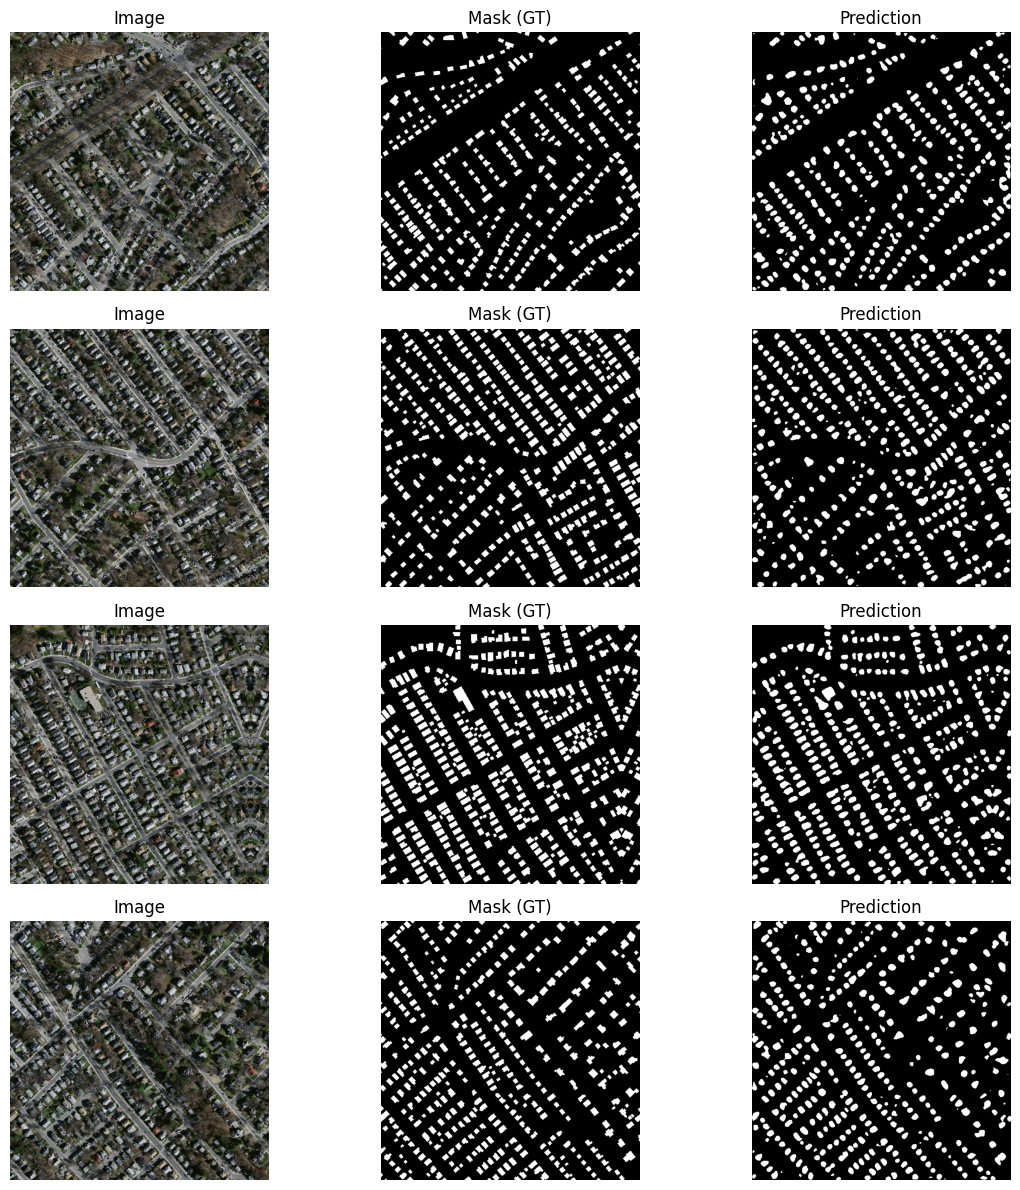

In [ ]:
# -------------------------
# 9) Visualize predictions
# -------------------------
def show_batch_predictions(loader, n_show=4):
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
    with torch.no_grad():
        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

    imgs = imgs.cpu().permute(0,2,3,1).numpy()
    # unnormalize for viewing
    imgs = (imgs * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN))
    imgs = np.clip(imgs, 0, 1)

    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    n = min(n_show, imgs.shape[0])
    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        plt.subplot(n,3,3*i+1); plt.imshow(imgs[i]); plt.title("Image"); plt.axis('off')
        plt.subplot(n,3,3*i+2); plt.imshow(masks[i,0], cmap='gray'); plt.title("Mask (GT)"); plt.axis('off')
        plt.subplot(n,3,3*i+3); plt.imshow(preds[i,0], cmap='gray'); plt.title("Prediction"); plt.axis('off')
    plt.tight_layout(); plt.show()

show_batch_predictions(test_dl, n_show=4)

## Cell — Inference speed (throughput demo)

We measure how many **megapixels per second (MPix/s)** the model processes:

- Runs forward passes over a few batches without computing loss.  
- Reports MPix/s — useful when comparing encoders, batch sizes, or hardware.

**Why this matters:**  
In rapid mapping, **throughput** matters. Lightweight encoders and AMP can push you towards **“minutes, not hours”** per Area of Interest.

In [ ]:
# ------------------------------------------------
# 10) Quick inference speed check (throughput demo)
# ------------------------------------------------
def measure_inference(loader, max_batches=10):
    model.eval()
    n_pix, t0 = 0, time.time()
    with torch.no_grad():
        for b, (imgs, _) in enumerate(loader):
            imgs = imgs.to(DEVICE)
            _ = model(imgs)
            n_pix += imgs.shape[0] * imgs.shape[2] * imgs.shape[3]
            if b+1 >= max_batches:
                break
    dt = time.time() - t0
    mpix_per_s = (n_pix / 1e6) / dt
    print(f"Inference speed: {mpix_per_s:.1f} MPix/s over {max_batches} batches")
measure_inference(test_dl, max_batches=10)

Inference speed: 8.5 MPix/s over 10 batches
